## Lp Regularisation Test

In [12]:
%load_ext autoreload
%autoreload 2

import math
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from pathlib import Path
from context import LocalLearning
from LocalLearning.Trainers import CETrainer
from LocalLearning.Regularizers import LpReg
from LocalLearning import HiddenLayerModel
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
import os
import copy
from scipy import stats

plt.style.use(['seaborn-paper', "./PRLDoubleCol.mplstyle"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [8]:
# Hyper Parameters
BATCH_SIZE = 1000
LEARNING_RATE = 1e-3
NUMBER_OF_EPOCHS = 100
p = 2

In [4]:
class LpRegModel(HiddenLayerModel):
    
    # default parameters
    pSet = {
        "in_size": 32*32*3,
        "hidden_size": 2000,
        "n": 4.5,
        "p": 3.0,
        "no_classes": 10,
        "tau": 10, # regularizing cutoff
    }
    
    def __init__(self, params: dict=None, sigma: float=None, bn=False, dtype: torch.dtype=torch.float32, **kwargs):
        super(LpRegModel, self).__init__()
        if type(params) != type(None):
            self.pSet["in_size"] = params["in_size"]
            self.pSet["hidden_size"] = params["hidden_size"]
            self.pSet["p"] = params["p"]
            self.pSet["n"] = params["n"]
            self.pSet["no_classes"] = params["no_classes"]
            self.pSet["tau"] = params["tau"]
            
        self.dtype = dtype
        self.flatten = nn.Flatten()
        
        # define linear mapping between input and hidden layer
        # creating the representations
        # same fashion as in KHL3 for optimal control
        self.W = torch.zeros((self.pSet["in_size"], self.pSet["hidden_size"]), dtype=self.dtype)

        # if sigma not explicitely specified, use Keiman He initialisation
        # scheme for ReLU activation functions
        if type(sigma) == type(None):
            sigma = math.sqrt(2 / self.pSet["in_size"])
        
        self.W.normal_(mean=0.0, std=sigma)
        self.W = nn.Parameter(self.W)
        
        self.ReLU = nn.ReLU()
        
        # define second mapping
        modules = []
        if bn: # check whether batch norm was specified or not
            modules.append(nn.BatchNorm1d(self.pSet["hidden_size"]))
        modules.append(
            nn.Linear(self.pSet["hidden_size"], self.pSet["no_classes"], bias=False)
        )
        self.dense = nn.Sequential(*modules)
        
    def hidden(self, x: torch.Tensor):
        x_flat = self.flatten(x)
        return x_flat @ self.W
        
    def forward(self, x: torch.Tensor):
        hidden = self.hidden(x)
        latent_activation = torch.pow(self.ReLU(hidden), self.pSet["n"])
        return self.dense(latent_activation), hidden

In [10]:
pSet = LpRegModel.pSet
pSet["in_size"] = 28**2
pSet["hidden_size"] = 2000
model = LpRegModel(params=pSet, bn=False)
model.to(device)
model.train()

LpRegModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (ReLU): ReLU()
  (dense): Sequential(
    (0): Linear(in_features=2000, out_features=10, bias=False)
  )
)

In [6]:
train_data = LocalLearning.LpUnitMNIST(
    root="../data/MNIST",
    train=True,
    p=pSet["p"],
)
dataloader_train = LocalLearning.DeviceDataLoader(
    train_data,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True,
)
test_data = LocalLearning.LpUnitMNIST(
    root="../data/MNIST",
    train=False,
    p=pSet["p"],
)
dataloader_test = LocalLearning.DeviceDataLoader(
    test_data,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

/storA/LocalLearning/LocalLearning/src/LocalLearning/LocalLearning.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.dataset.targets = torch.tensor(self.dataset.targets)


In [13]:
@LpReg(alpha_Lp=1e-3, p=2.0)
class LpTrainer(CETrainer):
    pass

In [14]:
lpTrainer = LpTrainer(model, device, learning_rate=LEARNING_RATE, dtype=torch.float64)
lpTrainer.run(dataloader_train, dataloader_test, no_epochs=NUMBER_OF_EPOCHS)

  0%|          | 0/100 [00:00<?, ?epoch/s]

In [15]:
def cov(
    dataloader: DataLoader, 
    model: HiddenLayerModel, 
    device: torch.device, 
    dtype: torch.dtype=torch.float32,
):
    
    with torch.no_grad():
        
        noE = model.pSet["hidden_size"]
        
        # initialize stat tensors
        auto_corr = torch.zeros((noE, noE), device=device, dtype=dtype)
        mean = torch.zeros((noE,), device=device, dtype=dtype)
        pop_size = 0
        
        # shift K - estimate of the mean
        f, _ = next(iter(dataloader))
        K = f.mean()
        
        
        for x, _ in dataloader:
            pop_size += len(x)
            pred = model.hidden(x.to(device))
            data = pred - K
            auto_corr += data.T @ data
            mean += data.sum(axis=0, dtype=dtype)
                
        cov = auto_corr - mean[None].T @ mean[None] / pop_size
        cov /= pop_size - 1
        
        return cov.clone()

In [16]:
model.eval()
cxx = cov(dataloader_test, model, device)
lambda_n, _ = torch.linalg.eigh(cxx)
lambda_sorted, _ = torch.sort(lambda_n, descending=True)
lambda_numpy = lambda_sorted.detach().cpu().numpy()

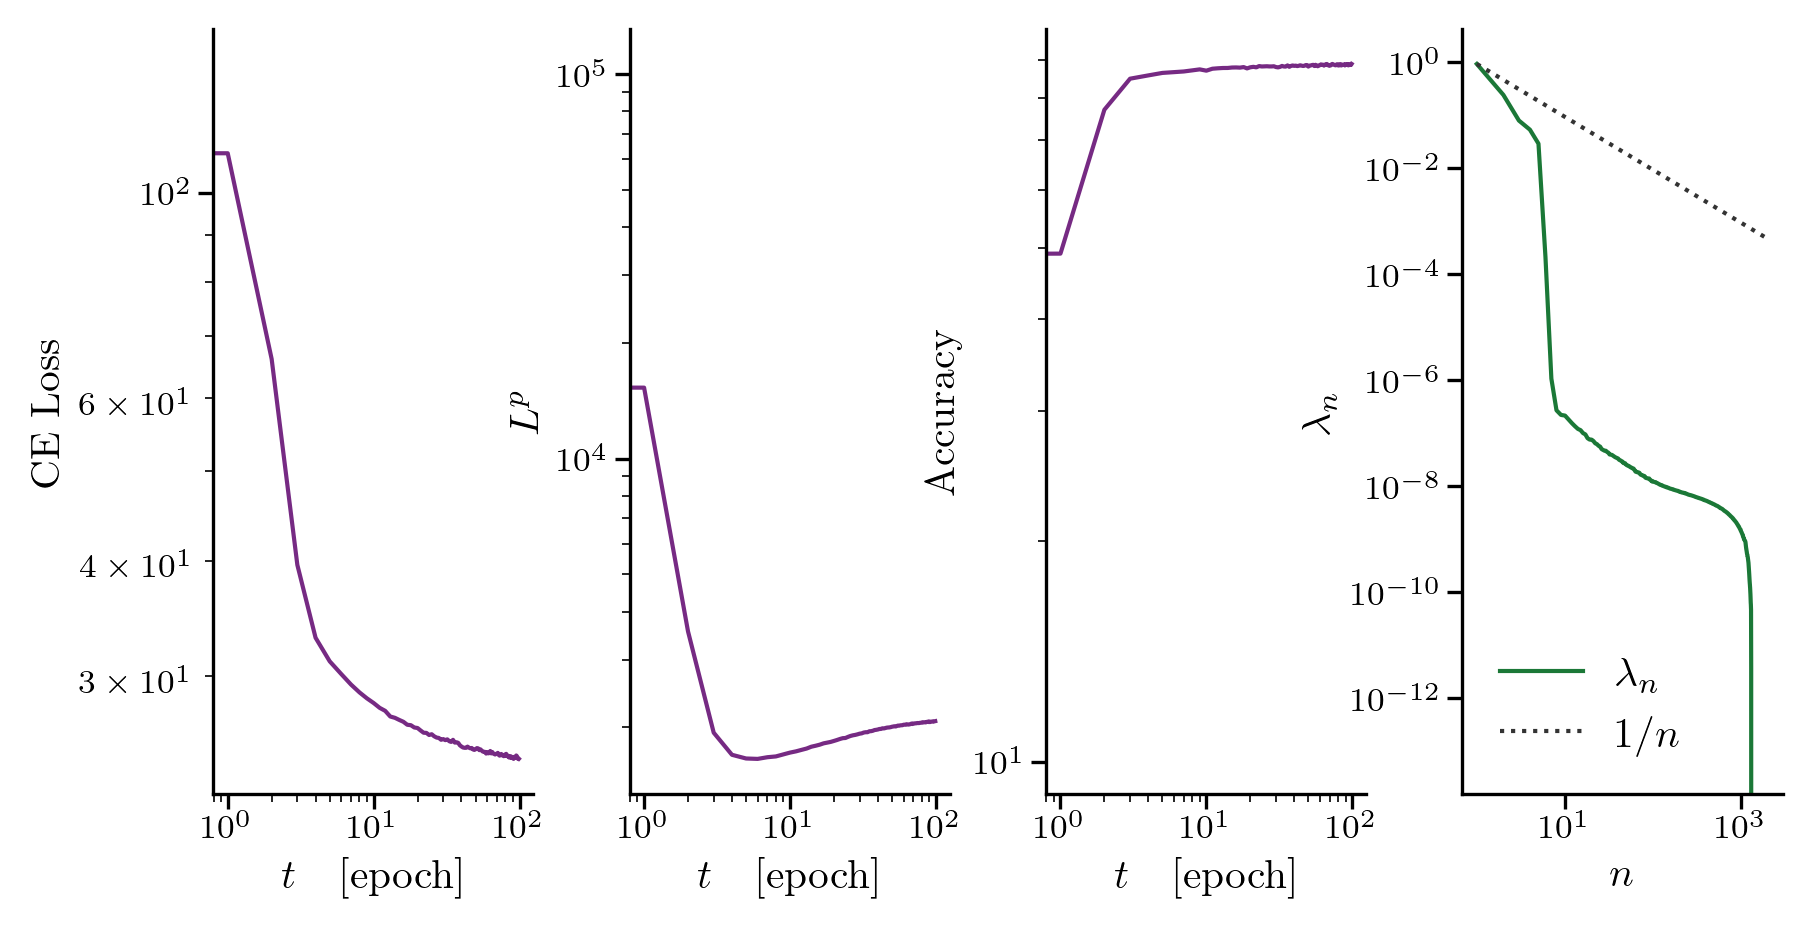

In [20]:
loss = np.array(lpTrainer.log["loss"])
ce_loss = np.array(lpTrainer.log["ce_loss"])
eval_acc = np.array(lpTrainer.log["eval_acc"])
lp_loss = np.array(lpTrainer.log["LpReg_loss"])
lp_score = np.array(lpTrainer.log["eval_LpReg_score"])


fig, axs = plt.subplots(1, 4)
n = np.arange(1, len(lambda_numpy)+1)
axs[0].loglog(ce_loss, color='#762a83')
axs[0].set_xlabel(r"$t \quad [\textrm{epoch}]$")
axs[0].set_ylabel(r"CE Loss")

axs[1].loglog(lp_loss, color='#762a83')
axs[1].set_xlabel(r"$t \quad [\textrm{epoch}]$")
axs[1].set_ylabel(r"$L^{p}$")

axs[2].loglog(100.0*eval_acc, color='#762a83')
axs[2].set_xlabel(r"$t \quad [\textrm{epoch}]$")
axs[2].set_ylabel(r"Accuracy")

spec_line = axs[3].loglog(n, lambda_numpy, color='#1b7837')
norm_line = axs[3].loglog(n, lambda_numpy[0]*n[0] / n, color='#333333', linestyle=":")
axs[3].set_xlabel(r"$n$")
axs[3].set_ylabel(r"$\lambda_{n}$")
axs[3].legend([r"$\lambda_{n}$", r"$1/n$"])
plt.show()